# Setup

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import rotate
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as PSNR
from scipy import signal

plt.gray()

<Figure size 640x480 with 0 Axes>

# 2. Fourier Analysis

## Toy Image

10496.0


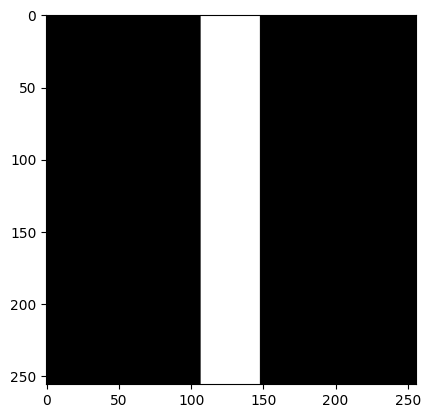

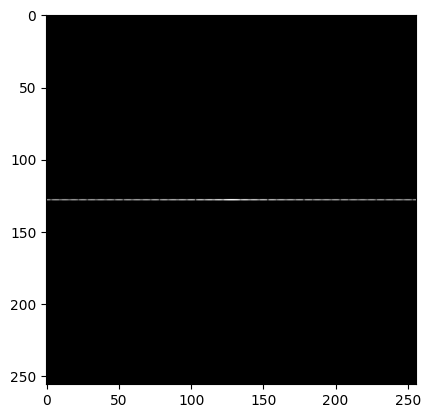

In [3]:
toy = np.zeros((256,256))
toy[:,107:148] = 1
print(np.abs(np.fft.fft2(toy))[0, 0])
plt.imshow(toy)
plt.show()



f_toy = np.fft.fftshift(np.fft.fft2(toy))
plt.imshow(np.log(np.abs(f_toy) + 1))
plt.show()  

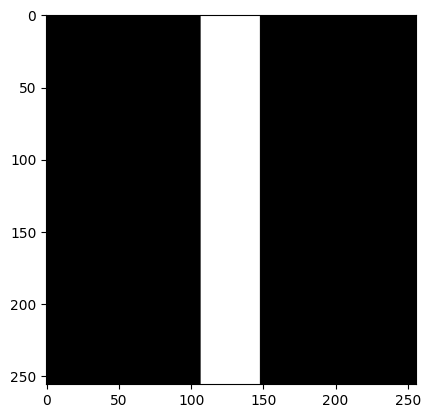

In [4]:
f_toy = np.fft.fft2(toy)
f_toy_amp = np.abs(f_toy)
f_toy_phase = np.angle(f_toy)
plt.imshow(np.fft.fftshift(f_toy_phase))
plt.imshow(np.fft.ifft2(f_toy_amp*np.exp(1j*f_toy_phase)).real)
plt.show()

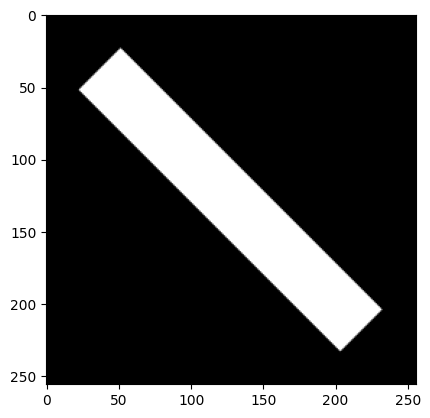

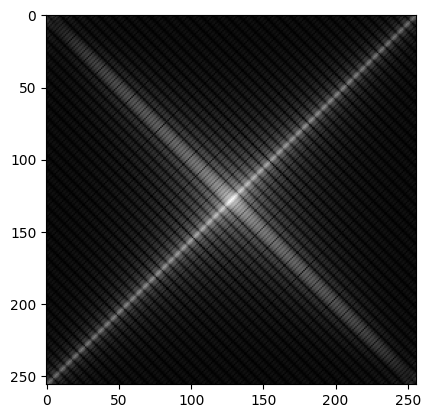

In [5]:
toy_rotated = rotate(toy, 45)
plt.imshow(toy_rotated)
plt.show()
f_rotated = np.fft.fftshift(np.fft.fft2(toy_rotated))
plt.imshow(np.log(np.abs(f_rotated) + 1))
plt.show()

## Contribution to Image Info

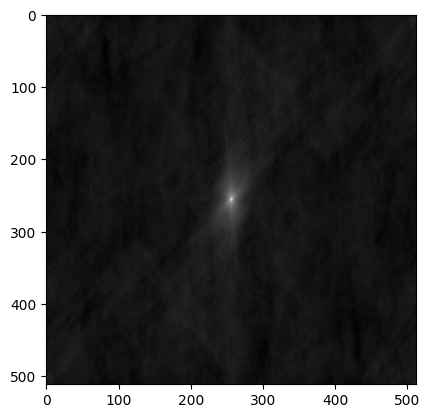

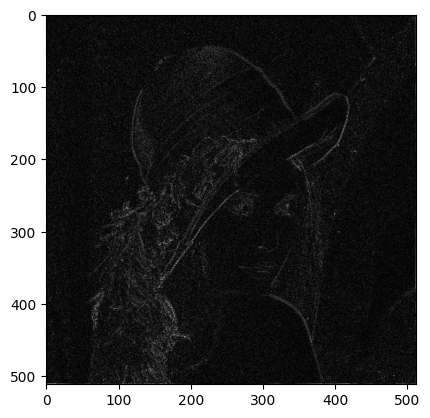

In [6]:
lena = rgb2gray(imread('lena.tiff'))

f_lena = np.fft.fft2(lena)
lema_amp = np.abs(f_lena)
lema_phase = np.angle(f_lena)

reconstructed_amp = np.fft.ifftshift(np.fft.ifft2(lema_amp))
reconstructed_phase = np.fft.ifft2(np.exp(1j*lema_phase))
plt.imshow(np.log(1 + np.abs(reconstructed_amp)))
plt.show()
plt.imshow(np.log(1 + np.abs(reconstructed_phase)))
plt.show()

# 3. Noise Reduction in the Frequency Domain

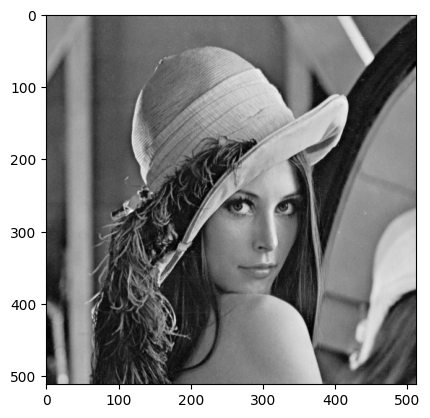

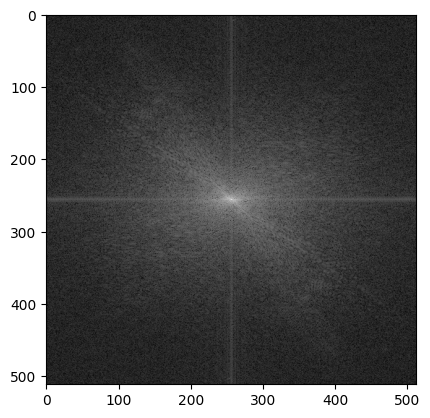

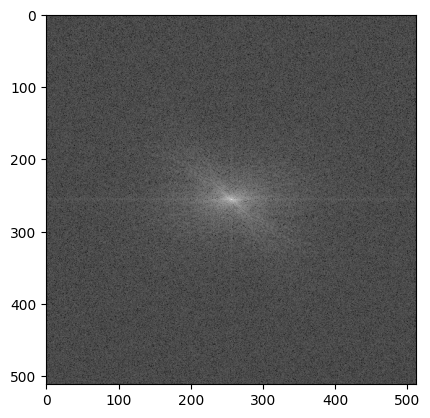

In [14]:
noisy_lena = random_noise(lena, mode='gaussian', clip=True, var=0.005)

f_lena = np.fft.fft2(lena)
f_noisy_lena = np.fft.fft2(noisy_lena)

plt.imshow(lena)
plt.show()
plt.imshow(np.log(1 + np.abs(np.fft.fftshift(f_lena))))
plt.show()
plt.imshow(np.log(1 + np.abs(np.fft.fftshift(f_noisy_lena))))
plt.show()

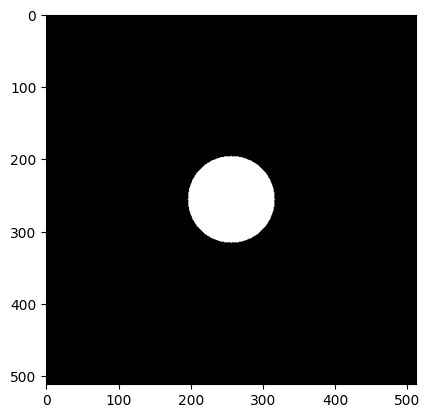

23.01354305699555


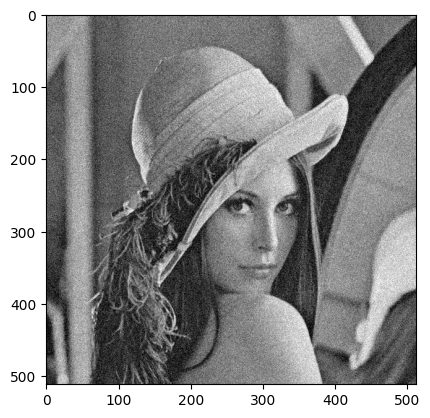

27.455493410314396


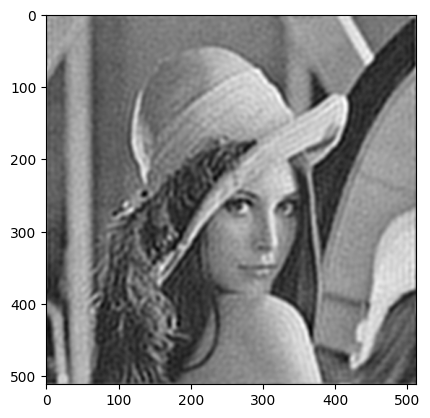

In [17]:
from skimage.morphology import disk

def make_disk(r):
    height, width = lena.shape
    h = disk(r)
    im = np.zeros((height, width))
    im[height//2-r: height//2+r+1, width//2-r: width//2+r+1] = h
    return im

lowpass60 = make_disk(60)
plt.imshow(lowpass60)
plt.show()

denoised_lena60 = np.fft.ifft2(f_noisy_lena * np.fft.ifftshift(lowpass60)).real
print(PSNR(lena, noisy_lena))
plt.imshow(noisy_lena)
plt.show()
print(PSNR(lena, denoised_lena60))
plt.imshow(denoised_lena60)
plt.show()

22.508169036932205


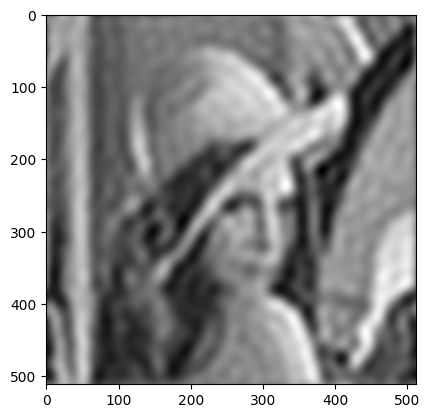

In [24]:
lowpass20 = make_disk(20)

denoised_lena20 = np.fft.ifft2(f_noisy_lena * np.fft.ifftshift(lowpass20)).real
print(PSNR(lena, denoised_lena20))
plt.imshow(denoised_lena20)
plt.show()

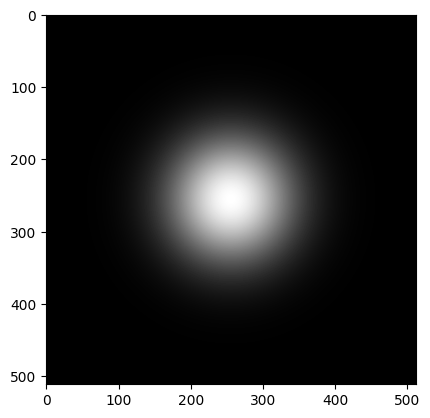

29.208842694350263


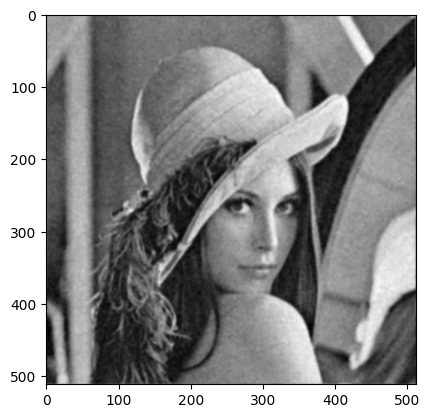

In [25]:
def gaussian_filter(n_rows, n_cols, stdv):
    """
    Returns a 2d Gaussian image filter.
    """
    g_r = signal.windows.gaussian(n_rows, stdv)
    g_c = signal.windows.gaussian(n_cols, stdv)
    G = np.outer(g_r, g_c)
    G /= np.sum(G)
    G /= G.max()
    return G

gaussian = gaussian_filter(*lena.shape, 60)
plt.imshow(gaussian)
plt.show()
denoised_lena_gaussian = np.fft.ifft2(f_noisy_lena * np.fft.ifftshift(gaussian)).real
print(PSNR(lena, denoised_lena_gaussian))
plt.imshow(denoised_lena_gaussian)
plt.show()


# 4. Filter Design

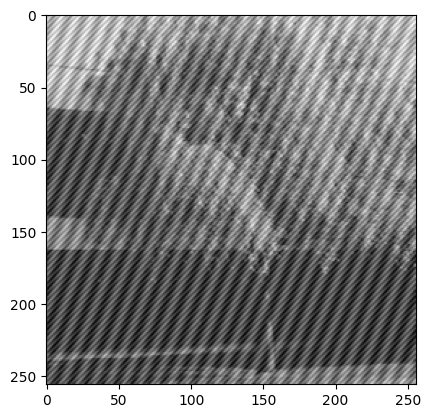

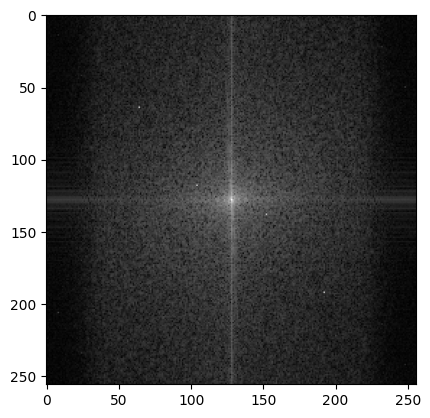

In [26]:
toy = imread('frequnoisy.tif').astype(np.float64)/255
f_toy = np.fft.fft2(toy)
plt.imshow(toy)
plt.show()
plt.imshow(np.log(1 + np.abs(np.fft.fftshift(f_toy))))
plt.show()

Removing freqs with coords: [(0, 255), (10, 24), (64, 64), (192, 192), (246, 232), (251, 0), (252, 0), (253, 1), (254, 0), (255, 0), (255, 1), (255, 255)]


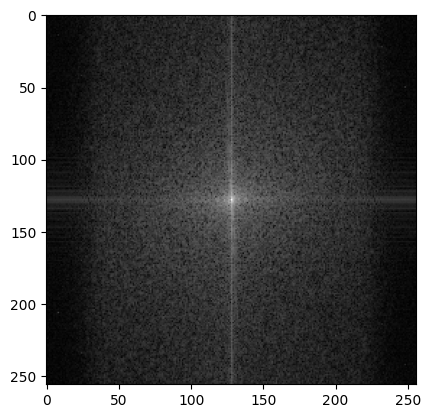

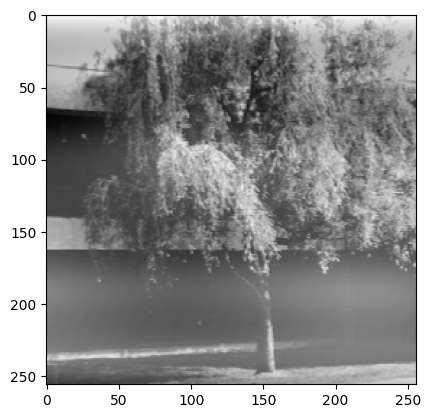

In [68]:
def get_peak_coords(image, num_peaks):
    # Peak detection using convolution
    kernel = np.array([[1, 1, 1],
                       [1, -8, 1],
                       [1, 1, 1]])
    masked_image = np.abs(signal.convolve2d(image, kernel, mode='same'))
    threshold = np.sort(masked_image.flatten())[- (num_peaks + 1)]
    peaks = np.nonzero(masked_image > threshold)
    return [*zip(*peaks)]

def remove_high_freq_peaks(f, ignorance_radius=20, peaks=20):
    F = np.fft.fft2(f)
    coords = get_peak_coords(np.abs(F), peaks)
    high_freq_coords = [coord for coord in coords if np.sqrt(coord[0]**2 + coord[1]**2) > ignorance_radius]
    print("Removing freqs with coords:", high_freq_coords)
    for x, y in high_freq_coords:
        F[x, y] = F[-x, y]
    plt.imshow(np.log(1 + np.abs(np.fft.fftshift(F))))
    plt.show()
    return np.fft.ifft2(F).real

toy_denoised = remove_high_freq_peaks(toy)
plt.imshow(toy_denoised)
plt.show()